<a href="https://colab.research.google.com/github/seungjae6874/Deeplearning/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

총 배치의 수 : 600
[Epoch:    1] cost = 1.459681034
[Epoch:    2] cost = 1.056225181
[Epoch:    3] cost = 0.909611285
[Epoch:    4] cost = 0.824264765
[Epoch:    5] cost = 0.766346931
[Epoch:    6] cost = 0.723664641
[Epoch:    7] cost = 0.690459251
[Epoch:    8] cost = 0.663650393
[Epoch:    9] cost = 0.641416609
[Epoch:   10] cost = 0.622572362
[Epoch:   11] cost = 0.606332421
[Epoch:   12] cost = 0.592147350
[Epoch:   13] cost = 0.579614162
[Epoch:   14] cost = 0.568425477
[Epoch:   15] cost = 0.558374882
[Epoch:   16] cost = 0.549262643
[Epoch:   17] cost = 0.540960014
[Epoch:   18] cost = 0.533348918
[Epoch:   19] cost = 0.526336133
[Epoch:   20] cost = 0.519852579
[Epoch:   21] cost = 0.513828397
[Epoch:   22] cost = 0.508213758
[Epoch:   23] cost = 0.502961040
[Epoch:   24] cost = 0.498036295
[Epoch:   25] cost = 0.493410319
[Epoch:   26] cost = 0.489045858
[Epoch:   27] cost = 0.484921157
[Epoch:   28] cost = 0.481017530
[Epoch:   29] cost = 0.477316290
[Epoch:   30] cost = 0.473795

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


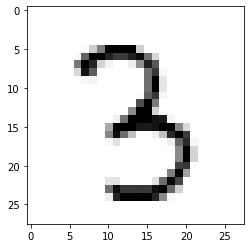

In [4]:

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.init
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#랜덤 시드 고정
torch.manual_seed(777)

#GPU 사용가능이면 랜덤 시드 고정
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

learning_rate = 0.001
training_epochs = 30 #전체 데이터를 15번 사용해서 학습시키겠다는 의미
batch_size = 100 # 한번 batch할때 학습시킬 데이터의 수를 의미, iteration은 epoch를 나누어서 실행하는 수이다
#ex epoch = 20이면 전체 데이터를 총 20번 반복해서 학습한다는 뜻이고 
#만약 iteration이 4이면 총 epoch를 20번 돌기위해 반복문을 4번 돌리는 것이고 한번 돌릴 때 즉 5번의 전체 데이터셋을 사용한다는 의미

#데이터로더를 사용하여 데이터를 다루기 위해 데이터셋 정의

mnist_train = dsets.MNIST(root='MNIST_data/', #다운로드 경로 지정
                          train = True, #True로 하면 훈련 데이터로 다운받게 된다,즉 FALSE이면 훈련데이터 다운 안받음
                           transform=transforms.ToTensor(), #텐서로 변환
                          download = True)

mnist_test = dsets.MNIST(root = 'MNIST_data/',
                        train = False,
                        transform=transforms.ToTensor(),
                        download = True)
#데이터로더를 사용하여 배치크기를 지정해준다. 만약 데이터셋과 데이터로더가 기억이 안나면 '미니배치와 데이터로드'복습

down_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size = batch_size,
                                          shuffle=True,
                                          drop_last = True) #drop_last는 마지막에 남는 데이터는 버림
#클래스 모델 설계 (conv + maxpool + fc)

class CNN(torch.nn.Module):
  
  def __init__(self):
    super(CNN,self).__init__()
    #첫번째 층
    #Img input shape(?,28,28,1)
    #CONV -> (?28,28,32)
    #POOL -> (?, 14,14,32)
    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1,32,kernel_size = 3, stride = 1, padding = 1), #kernel_size는 filter의 너비,높이사이즈 이다 3 * 3
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    #2번째 층
    #Img input shape(?,14,14,32)
    #Conv-> (?,14,14,64)
    #POOL -> (?,7,7,64)
    self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    #FC층 7*7*64 -> 10output으로
    self.fc = torch.nn.Linear(7*7*64,10,bias = True)

    #FC층 한정으로 가중치 초기화
    torch.nn.init.xavier_uniform_(self.fc.weight)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out
    
model = CNN().to(device)
linear = torch.nn.Linear(784,10,bias = True).to(device)

criterion = torch.nn.CrossEntropyLoss().to(device) #비용함수에 소프트맥스가 포함
optimizer = torch.optim.Adagrad(linear.parameters(), lr = learning_rate)

#총 배치 수 출력
total_batch = len(down_loader)
print('총 배치의 수 : {}'.format(total_batch))


for epoch in range(training_epochs):
    avg_cost = 0
    
    for X, Y in down_loader:
        X = X.view(-1,28*28).to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis,Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
        
    print('[Epoch: {:>4}] cost = {:>.9f}'.format(epoch + 1, avg_cost))


print('Learning Finished!')

with torch.no_grad():
  X_test = mnist_test.test_data.view(-1,28*28).float().to(device)
  Y_test = mnist_test.test_labels.to(device)

  prediction = linear(X_test)
  correct_prediction = torch.argmax(prediction,1) == Y_test
  accuracy = correct_prediction.float().mean()
  print("Accuracy : ",accuracy.item())

  r = random.randint(0,len(mnist_test)-1)
  X_single_data = mnist_test.test_data[r:r+1].view(-1,28*28).float().to(device)
  Y_single_data = mnist_test.test_labels[r:r+1].to(device)

  print("Label: ",Y_single_data.item())
  single_prediction = linear(X_single_data)
  print("Prediction : ",torch.argmax(single_prediction,1).item())

  plt.imshow(mnist_test.test_data[r:r+1].view(28,28),cmap = 'Greys', interpolation = 'nearest')
  plt.show()
